<a href="https://colab.research.google.com/github/sunshine-sanjib/mask_detection/blob/main/facemask_dectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

# Create a clean directory for the data
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the zip file
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Your files are in:", extract_path)

Extraction complete! Your files are in: /content/dataset


In [ ]:
!ls -R /content/dataset

/content/dataset:
data

/content/dataset/data:
with_mask  without_mask

/content/dataset/data/with_mask:
with_mask_1000.jpg  with_mask_1840.jpg	with_mask_267.jpg   with_mask_3518.jpg
with_mask_1001.jpg  with_mask_1841.jpg	with_mask_2680.jpg  with_mask_3519.jpg
with_mask_1002.jpg  with_mask_1842.jpg	with_mask_2681.jpg  with_mask_351.jpg
with_mask_1003.jpg  with_mask_1843.jpg	with_mask_2682.jpg  with_mask_3520.jpg
with_mask_1004.jpg  with_mask_1844.jpg	with_mask_2683.jpg  with_mask_3521.jpg
with_mask_1005.jpg  with_mask_1845.jpg	with_mask_2684.jpg  with_mask_3522.jpg
with_mask_1006.jpg  with_mask_1846.jpg	with_mask_2685.jpg  with_mask_3523.jpg
with_mask_1007.jpg  with_mask_1847.jpg	with_mask_2686.jpg  with_mask_3524.jpg
with_mask_1008.jpg  with_mask_1848.jpg	with_mask_2687.jpg  with_mask_3525.jpg
with_mask_1009.jpg  with_mask_1849.jpg	with_mask_2688.jpg  with_mask_3526.jpg
with_mask_100.jpg   with_mask_184.jpg	with_mask_2689.jpg  with_mask_3527.jpg
with_mask_1010.jpg  with_mask_1850.jpg	

In [ ]:
# UPDATE THIS PATH based on your 'ls' output
DIRECTORY = "/content/dataset/data"
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Path to your extracted data
DIRECTORY = "/content/dataset/data" # Corrected path
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

# Load and Preprocess images
# (Note: This is a simplified version. For large datasets, use flow_from_directory)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DIRECTORY,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])
model.fit(train_generator, epochs=5) # Increase epochs for better accuracy

# Save the model
model.save("mask_detector.h5")

Found 6043 images belonging to 2 classes.


/tmp/ipython-input-1473143288.py:40: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 68/189 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.6964 - loss: 0.6740

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7997 - loss: 0.4564
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9661 - loss: 0.0996
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.9740 - loss: 0.0697
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.9759 - loss: 0.0648
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.9797 - loss: 0.0558


In [ ]:
import cv2
import numpy as np
import io
import base64
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow

# 1. Helper function to convert JavaScript webcam image to OpenCV format
def js_to_image(js_reply):
    """
    Converts a JavaScript base64 image into an OpenCV BGR image.
    """
    # Decode base64 image
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    # Convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# 2. JavaScript to start and capture the webcam
def video_stream():
  js = Javascript('''
    var video;
    var container = document.createElement('div');
    var captureCanvas = document.createElement('canvas');
    var videoStream;

    async function streamWebcam() {
      video = document.createElement('video');
      video.style.display = 'block';
      videoStream = await navigator.mediaDevices.getUserMedia({ video: true });
      video.srcObject = videoStream;
      await video.play();

      container.appendChild(video);
      document.body.appendChild(container);

      captureCanvas.width = video.videoWidth;
      captureCanvas.height = video.videoHeight;
    }

    async function captureFrame() {
      var context = captureCanvas.getContext('2d');
      context.drawImage(video, 0, 0);
      return captureCanvas.toDataURL('image/jpeg', 0.8);
    }

    window.streamWebcam = streamWebcam;
    window.captureFrame = captureFrame;
    ''')
  display(js)

# 3. Load the default Face Detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print("Helper functions and face detector loaded!")

Helper functions and face detector loaded!


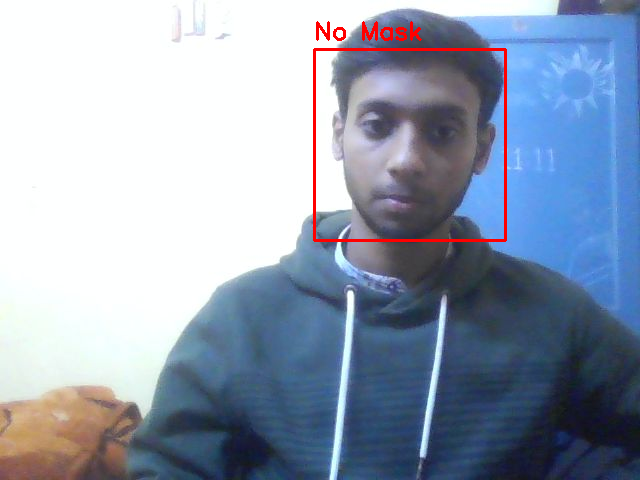

Webcam Error: ReferenceError: captureFrame is not defined


In [ ]:
import time
from tensorflow.keras.models import load_model
from IPython.display import clear_output

# Start the webcam stream
video_stream()
eval_js('streamWebcam()')

# Load your trained model
try:
    mask_model = load_model("mask_detector.h5")
    print("Model loaded successfully!")
except:
    print("Error: mask_detector.h5 not found. Please run the training step first.")

label_map = {0: "Mask On", 1: "No Mask"}
color_map = {0: (0, 255, 0), 1: (0, 0, 255)} # Green for mask, Red for no mask

while True:
    try:
        # Capture frame from browser
        js_image = eval_js('captureFrame()')
        if not js_image:
            break

        frame = js_to_image(js_image)

        # Detect faces
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            # Crop and preprocess face for the model
            face_img = frame[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (224, 224))
            face_img = np.reshape(face_img, (1, 224, 224, 3)) / 255.0

            # Predict mask/no mask
            prediction = mask_model.predict(face_img, verbose=0)
            label = np.argmax(prediction)

            # Draw rectangle and text
            cv2.rectangle(frame, (x, y), (x+w, y+h), color_map[label], 2)
            cv2.putText(frame, label_map[label], (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_map[label], 2)

        # Clear output to prevent long scrolling and show the updated frame
        clear_output(wait=True)
        cv2_imshow(frame)

    except Exception as err:
        print(f"Webcam Error: {err}")
        break